# 3. Stablishing Comunication with the NCBI through API
## 3.1. Configuration and link
A configuration file is made in py which corresponds to the details of the comunication and will be stored in gitignore.

# 1 Sequences Scrapping - Introduction
This notebook is an automated tool designed for retrieving 16S rRNA sequences from the GenBank database, managed by the National Center for Biotechnology Information (NCBI). The focus is on sequences associated with various genera found in water bodies, as part of a broader study.

# Key Steps and Features:
### Reading Genera List:
The script starts by reading a list of genera from an Excel file. These genera are of particular interest for the study.
### NCBI Database Interaction:
It establishes a connection with the NCBI database and iteratively queries each genus. This process involves fetching the unique identifiers (accession numbers) of the relevant 16S rRNA sequences.
### Data Storage and Organization:
The retrieved data, mainly accession numbers, are stored in a dictionary for subsequent processing.
### Sequence Retrieval and Verification:
The notebook includes a function for fetching the actual sequence data from GenBank using the accession numbers. There's also a provision for validating the retrieved sequences.
### Data Manipulation:
Extensive data manipulation is performed, including transforming and merging dataframes to align the sequence data with the original genera list.
### Phylogenetic Analysis:
The primary goal is to align these sequences to construct a dendrogram, offering insights into the genomic relationships among the genera.
The notebook implements the UPGMA (Unweighted Pair Group Method with Arithmetic Mean) method for tree construction, with a mention of the possibility of using Neighbor-Joining (NJ).
The script includes steps for sequence alignment, conversion to FASTA format, and preparation for phylogenetic tree construction.
### Bootstrap Analysis for Tree Reliability:
To assess the reliability of the phylogenetic trees, a bootstrap analysis is performed. This involves generating multiple pseudo-replicated datasets and analyzing the resulting tree structures.
### Consensus Tree Construction:
A consensus tree is constructed from the bootstrap trees, providing a robust representation of the phylogenetic relationships.
### Additional Notes:
The script contains several safety and optimization measures, such as using time.sleep to avoid overloading the NCBI server and handling exceptions during sequence retrieval.
There's a focus on improving the script, including suggestions for secure API key storage, error handling enhancements, and code documentation.

I am having problems installilng packages from the terminal, so I am installing the biophyton from here.

# 2. Preprocessing the data 
This notebook has been worked in colab and in vsc, the code is silence eitherway.
## 2.1 Mounting the data in colab

In [32]:
'''from google.colab import drive  #silence for vscode
drive.mount('/content/drive')

#change the path
os.chdir('/content/drive/My Drive/MIC')'''

"from google.colab import drive  #silence for vscode\ndrive.mount('/content/drive')\n\n#change the path\nos.chdir('/content/drive/My Drive/MIC')"

## 2.2 Importing the necesary libraries

In [33]:
# for colab and in the terminal 
#!pip install biopython
# Create organized folder structure
from pathlib import Path
import time
import pandas as pd
import numpy as np
from Bio import Phylo
import matplotlib.pyplot as plt
import os
from Bio import Entrez, SeqIO, AlignIO
import subprocess
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
#from Bio.Phylo import draw
from random import choice
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.Consensus import majority_consensus
from typing import Dict, List, Optional
from datetime import datetime
import logging
from dataclasses import dataclass

In [34]:
# For Colab
'''
from Bio import Phylo
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))  # Adjust size as needed
Phylo.draw(consensus_tree)
plt.show()
'''

'\nfrom Bio import Phylo\nimport matplotlib.pyplot as plt\nplt.figure(figsize=(15, 10))  # Adjust size as needed\nPhylo.draw(consensus_tree)\nplt.show()\n'

## 2.3. Creating a Folder for the Results: Data_tree
dedicated folder to keep the results and bootstraping of the present notebook  

In [35]:
# For VSCode
base_dir = Path("/home/beatriz/MIC/2_Micro/data_tree")
bootstrap_dir = base_dir / "bootstrapping"
bootstrap_dir.mkdir(exist_ok=True)

# For Colab
'''
from google.colab import drive
drive.mount('/content/drive')
base_dir = Path('/content/drive/My Drive/MIC/data')
bootstrap_dir = base_dir / "bootstrapping"
bootstrap_dir.mkdir(exist_ok=True)
'''

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\nbase_dir = Path(\'/content/drive/My Drive/MIC/data\')\nbootstrap_dir = base_dir / "bootstrapping"\nbootstrap_dir.mkdir(exist_ok=True)\n'

## 2.4. Loadging, cleaning and preparing the dataframe
from book 3_feature_selection we importe 'selected' DataFrame. 

In [36]:
# Read the Excel file
selected = pd.read_excel("data/finalist_dfs.xlsx", sheet_name='checked_genera', header=[0,1,2,3,4,5,6,7])
# Drop first row specifically (index 0 which contains NaNs)
selected = selected.drop(index=0)
# Drop first column (the index column with Level1, Level2, etc)
selected = selected.drop(selected.columns[0], axis=1)
# Remove 'Unnamed' level names
selected.columns = selected.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# Setting index to Sites
selected= selected.set_index("Sites")
selected_taxa = selected.T
selected_taxa  = selected_taxa.reset_index()
selected_taxa.head()

Sites,level_0,level_1,level_2,level_3,level_4,level_5,level_6,level_7,site_1,site_2,...,site_61,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70
0,Category,,,,,,,,3.000000,1.00000,...,2.000000,2.000000,2.000000,2.00,2.000000,2.0,3.000000,3.000000,1.00,1.00
1,Clostridiales_Tissierellaceae_Anaerococcus,Bacteria,Firmicutes,Clostridia,Clostridiales,Tissierellaceae,Anaerococcus,81,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.00
2,Rhizobiales_Phyllobacteriaceae_Aquamicrobium,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Phyllobacteriaceae,Aquamicrobium,92,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.014657,0.010586,0.00,0.00
3,Rhodocyclales_Rhodocyclaceae_Azospira,Bacteria,Proteobacteria,Betaproteobacteria,Rhodocyclales,Rhodocyclaceae,Azospira,110,26.928048,1.85923,...,0.353291,0.571304,0.624133,0.26,4.518236,0.4,0.004886,0.000000,1.47,1.72
4,Actinomycetales_Dermabacteraceae_Brachybacterium,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Dermabacteraceae,Brachybacterium,140,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.054437,0.0,0.000000,0.021172,0.00,0.00


In [37]:
# Comunicating with the NCBI
from config import NCBI_API_KEY, NCBI_EMAIL
Entrez.email = NCBI_EMAIL
Entrez.api_key = NCBI_API_KEY

In [38]:
def setup_logging():
    """Configure logging to both file and console"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler('sequence_retrieval.log'),
            logging.StreamHandler()
        ]
    )

## 3.2. Selecting the Genera 
If necesary it is possible to retrieve only the wild strains and water environments like this
```search_term = f"{genus}[Orgn] AND 16S rRNA[Gene] AND wild[Properties] AND water[Environment]"
```

In [39]:
# Extract Genera from the multi-index and filter out empty strings
genera = [genus for genus in selected.columns.get_level_values(6).to_list() if genus.strip()]

# Dictionary to store the results
results = {}

## 3.3. Retriving Data from the NCBI
Following code is silent, so that I dont run it again by mistake and ask again the accession numbers to the NCBI

In [40]:
def search_sequences(
    genus: str,
    entrez: object,
    max_retries: int = 3,
    base_delay: int = 10,
    max_delay: int = 60
) -> Optional[List[str]]:
    """
    Search for sequences with improved error handling and validation.
    
    Args:
        genus: The genus name to search for
        entrez: Entrez object with configured email and API key
        max_retries: Maximum number of retry attempts
        base_delay: Initial delay between retries in seconds
        max_delay: Maximum delay between retries in seconds
    
    Returns:
        List of sequence IDs or None if unsuccessful
    """
    if not isinstance(genus, str) or not genus.strip():
        raise ValueError("Genus must be a non-empty string")
    if not hasattr(entrez, 'email') or not entrez.email:
        raise RuntimeError("Entrez email configuration missing")
    
    retry_count = 0
    delay = base_delay

    while retry_count < max_retries:
        try:
            search_term = (f"{genus}[Organism] AND " "(16S[All Fields] OR 16S ribosomal RNA[All Fields] OR "
                "16S rRNA[All Fields]) AND " "500:2000[Sequence Length]")
            
            logging.info(f"Attempting search for {genus} (attempt {retry_count + 1}/{max_retries})")
            # Search NCBI database
            handle = entrez.esearch(db="nucleotide", term=search_term, retmax=100)
            
            try:
                record = entrez.read(handle)
            except entrez.Parser.ValidationError as ve:
                logging.error(f"NCBI validation error: {str(ve)}")
                return None
            finally:
                handle.close()
            
            sequence_count = len(record.get('IdList', []))
            logging.info(f"Found {sequence_count} sequences for {genus}")
            
            if sequence_count > 0:
                return record['IdList']
            
            logging.warning(f"No sequences found for {genus}")
            
        except entrez.HTTPError as he:
            logging.error(f"NCBI HTTP error: {str(he)}")
        except entrez.URLError as ue:
            logging.error(f"NCBI connection error: {str(ue)}")
        except Exception as e:
            logging.error(f"Unexpected error: {str(e)}")
        
        if retry_count < max_retries:
            wait_time = min(delay * (2 ** (retry_count - 1)), max_delay)
            logging.info(f"Waiting {wait_time} seconds before retry...")
            time.sleep(wait_time)

            if retry_count >=max_retries:
                logging.error(f"Max retries ({max_retries}) reached for {genus}")
                return None
        return []

def retrieve_sequences(
    genera: List[str],
    entrez: object,
    output_file: str = "sequence_results.txt"
) -> Dict[str, List[str]]:
    """
    Retrieve sequences with comprehensive logging and error handling.
    
    Args:
        genera: List of genus names
        entrez: Configured Entrez object
        output_file: Path to save detailed results
    
    Returns:
        Dictionary mapping genera to their sequence IDs
    """
    setup_logging()
    logging.info(f"Starting sequence retrieval for {len(genera)} genera")
    
    results = {}
    missing_genera = []
    start_time = datetime.now()
    
    total_genera = len(genera)
    processed_count = 0
    
    for genus in genera:
        processed_count += 1
        logging.info(f"Processing {genus} ({processed_count}/{total_genera})")
        
        sequence_ids = search_sequences(genus, entrez)
        
        if sequence_ids:
            results[genus] = sequence_ids
        else:
            missing_genera.append(genus)
        
        success_rate = (len(results) / processed_count) * 100
        logging.info(f"Current success rate: {success_rate:.1f}%")
        
        time.sleep(10)
    
    # Generate summary
    elapsed_time = datetime.now() - start_time
    summary = f"""
    Sequence Retrieval Summary
    -------------------------
    Total genera processed: {total_genera}
    Successful retrievals: {len(results)}
    Failed retrievals: {len(missing_genera)}
    Success rate: {(len(results)/total_genera)*100:.1f}%
    Total time elapsed: {elapsed_time}

    Successful Genera:
    {'-' * 20}
    """ + '\n'.join(f"- {genus}: {len(ids)} sequences" for genus, ids in results.items()) + f"""

    Missing Genera:
    {'-' * 20}
    """ + '\n'.join(f"- {genus}" for genus in missing_genera)
    
    # Save summary to file
    with open(output_file, 'w') as f:
        f.write(summary)
    
    return results

In [41]:
# Calling the function
results = retrieve_sequences(genera, Entrez)

2025-01-05 02:06:15,582 - INFO - Starting sequence retrieval for 30 genera
2025-01-05 02:06:15,622 - INFO - Processing Anaerococcus (1/30)
2025-01-05 02:06:15,623 - INFO - Attempting search for Anaerococcus (attempt 1/3)
2025-01-05 02:06:17,415 - INFO - Found 100 sequences for Anaerococcus
2025-01-05 02:06:17,417 - INFO - Current success rate: 100.0%
2025-01-05 02:06:27,431 - INFO - Processing Aquamicrobium (2/30)
2025-01-05 02:06:27,441 - INFO - Attempting search for Aquamicrobium (attempt 1/3)
2025-01-05 02:06:28,938 - INFO - Found 100 sequences for Aquamicrobium
2025-01-05 02:06:28,942 - INFO - Current success rate: 100.0%
2025-01-05 02:06:38,953 - INFO - Processing Azospira (3/30)
2025-01-05 02:06:38,956 - INFO - Attempting search for Azospira (attempt 1/3)
2025-01-05 02:06:40,435 - INFO - Found 100 sequences for Azospira
2025-01-05 02:06:40,448 - INFO - Current success rate: 100.0%
2025-01-05 02:06:50,463 - INFO - Processing Brachybacterium (4/30)
2025-01-05 02:06:50,465 - INFO - 

In [42]:
print(f"Number of genera with sequences: {len(results)}")  # Add this to check if results exists

Number of genera with sequences: 29


## 3.4. Resulting accension numbers

In [43]:
# Print the results
for genus, ids in results.items():
    print(f"{genus}: {ids}")

Anaerococcus: ['2875007548', '2875007546', '2875007539', '2875007530', '2875007524', '2875007513', '2875007512', '2875007497', '2875003497', '2875003496', '2875001092', '2874986295', '2874986293', '2874986291', '2874986289', '2874986287', '2874986285', '2874986283', '2874986281', '2874986279', '2874986278', '2874986276', '2874986274', '2874986272', '2874986271', '2874986268', '2874986266', '2874986265', '2874986263', '2874986262', '2874986259', '2874986245', '2592352781', '2592352780', '2592352778', '2592352777', '2592352775', '2592352773', '2592352772', '2592352771', '2592352770', '2592352768', '2592352767', '2592352766', '2592352765', '2592352764', '2592352763', '2592352762', '2592352761', '2592352760', '2592352758', '2592352757', '2592352756', '2592352755', '2592352753', '2592352752', '2592348405', '2592348404', '2592348403', '2592348402', '2592348401', '2592348400', '2592348399', '2592348398', '2592348396', '2592348395', '2592336104', '2592336102', '2592336099', '2592336097', '2592

In [44]:
# Create a DataFrame from the dictionary
df_accension = pd.DataFrame(list(results.items()), columns=['Genus', 'IDs'])
df_accension.head(31)

,Genus,IDs
0,Anaerococcus,"[2875007548, 2875007546, 2875007539, 287500753..."
1,Aquamicrobium,"[2866741290, 1949157811, 1949157810, 286415392..."
2,Azospira,"[2815233668, 2815233665, 2815233662, 281523365..."
3,Brachybacterium,"[2159029981, 2872450823, 2815198619, 250302550..."
4,Brevibacterium,"[2873344496, 2604899977, 2604899975, 260489997..."
5,Bulleidia,"[283769288, 283769285, 283768955, 283768953, 2..."
6,Cellulosimicrobium,"[1789960006, 1789960004, 1789959999, 272548924..."
7,Clavibacter,"[2843295496, 2700718643, 2700712823, 259359025..."
8,Clostridium,"[2644340613, 2644058611, 2644058610, 264405860..."
9,Cohnella,"[2816454994, 2506558724, 1624308549, 162430854..."


## 3.5 Combining the Taxa with the Abundance Values in a Dataframe 

In [45]:
current_columns = selected_taxa.columns.tolist()
new_columns = ['Jointax', 'Kingdom','Phylum', 'Class', 'Order', 'Family', 'Genus', 'GID']
combined_columns= new_columns + current_columns[8:]
selected_taxa.columns = combined_columns

In [46]:
# Saving the intermediary results 
selected_taxa.to_excel("data_tree/jointax.xlsx")

## 3.6. Merging Taxa, Abundance and Accension Numbers on a dataframe

In [47]:
print(selected.columns.get_level_values(6).to_list())

['', 'Anaerococcus', 'Aquamicrobium', 'Azospira', 'Brachybacterium', 'Brevibacterium', 'Bulleidia', 'Cellulosimicrobium', 'Clavibacter', 'Clostridium', 'Cohnella', 'Corynebacterium', 'Enterococcus', 'Halomonas', 'Legionella', 'Methyloversatilis', 'Mycobacterium', 'Mycoplana', 'Neisseria', 'Novosphingobium', 'Oerskovia', 'Opitutus', 'Oxobacter', 'Paracoccus', 'Prevotella', 'Psb-m-3', 'Pseudarthrobacter', 'Pseudoalteromonas', 'Roseateles', 'Streptococcus', 'Thiobacillus']


In [48]:
# Merge the two DataFrames on the 'Genus' column
taxa_accension = pd.merge(selected_taxa, df_accension, on='Genus')

In [49]:
# Save the merged sequences to use making the dendrogram notebook
taxa_accension.to_csv('data_tree/taxa_accension.csv', index=False)

# 4. Retrieving Sequencies with the Accession Numbers
These numbers are the GenBank accession numbers, which are unique identifiers for sequences in the GenBank database. Following is to retrieve the actual sequences using these accession numbers.
## 4.1. Define get_sequence function and validate it

In [50]:
# Specify email (required by NCBI)
Entrez.email = "wattsbeatrizamanda@gmail.com"

# Retrieve the sequence for a given accession number
def get_sequence(accession):
    try:
       handle = Entrez.efetch(db="nucleotide", 
                             id=accession, 
                             rettype="fasta",  # Keep FASTA format
                             retmode="text")
       record = SeqIO.read(handle, "fasta")
       handle.close()
        
       sequence = str(record.seq)
       if sequence and len(sequence) > 0:  # Check if sequence exists and is not empty
           print(f"Got sequence of length {len(sequence)} for {accession}")
           return sequence
       else:
           print(f"Warning: Empty sequence for {accession}")
           return None
        
    except Exception as e:
        print(f"Failed to get sequence for {accession}: {e}")
        return None

Make the df with the accension numbers with the actual number and not just the index, code difficult to run in this machine

In [83]:
def validate_sequence(sequence):
    """Basic sequence validation"""
    return len(sequence) >= 500  # check if sequence is long enough

results =[]
# Loop over the rows in the DataFrame
for i, row in taxa_accension.iterrows():
    # Get the genus, GID and accession numbers for the current row
    genus = row['Genus']
    gid = row['GID']
    
    # Convert string representation of list to actual list 
    accession_numbers = row['IDs']

    # Debug - print current genus being processed
    print(f"Processing {genus}")

    # Initialize a variable to store the accession number that returns a valid sequence
    valid_accession = None

    # Loop over the accession numbers
    for accession in accession_numbers:
        # Retrieve the sequence
        sequence = get_sequence(accession)

        # Debug print
        if sequence:
            print(f"Sequence length: {len(sequence)}")

        # Check if a sequence was found and is valid
        if sequence is not None and validate_sequence(sequence):
            # Store the accession number and sequence
            valid_accession = accession
            valid_sequence = sequence
            break
    
    # If we found a valid sequence, add it to results
    if valid_accession is not None:
        results.append({
            'Genus': genus,
            'GID': gid,
            'Accession': valid_accession,
            'Sequence': valid_sequence
        })

    # Pause for 5 second
    time.sleep(5)

# Convert the list of results to a DataFrame
final_sequences = pd.DataFrame(results)

# Print some information about the results
print(f"\nNumber of sequences retrieved: {len(final_sequences)}")
print("\nFirst few rows:")
print(final_sequences.head(31))

Processing Anaerococcus
Got sequence of length 1101 for 2875007548
Sequence length: 1101
Processing Aquamicrobium
Got sequence of length 1333 for 2866741290
Sequence length: 1333
Processing Azospira
Got sequence of length 1057 for 2815233668
Sequence length: 1057
Processing Brachybacterium
Got sequence of length 1385 for 2159029981
Sequence length: 1385
Processing Brevibacterium
Got sequence of length 1283 for 2873344496
Sequence length: 1283
Processing Bulleidia
Got sequence of length 1617 for 283769288
Sequence length: 1617
Processing Cellulosimicrobium
Got sequence of length 722 for 1789960006
Sequence length: 722
Processing Clavibacter
Got sequence of length 1448 for 2843295496
Sequence length: 1448
Processing Clostridium
Got sequence of length 1657 for 2644340613
Sequence length: 1657
Processing Cohnella
Got sequence of length 1199 for 2816454994
Sequence length: 1199
Processing Corynebacterium
Got sequence of length 1736 for 2358697805
Sequence length: 1736
Processing Enterococcu

In [84]:
# Print the first few rows of the DataFrame
final_sequences.head(31)

,Genus,GID,Accession,Sequence
0,Anaerococcus,81,2875007548,CGCCTGTTCCTGGGGTTTCTCCGCCTGTGCCTGGGGTTTCTCCGCC...
1,Aquamicrobium,92,2866741290,CAAAGGGGAGCGGCAGACGGGTGAGTAACGCGTGGGAATCTACCCA...
2,Azospira,110,2815233668,GACCTTCTTCCATGGCGATCGGGGCGATCAGCTTGACGGTCATGCT...
3,Brachybacterium,140,2159029981,TACCATGCAGTCGACGATGACGACCGAGCTTGCTCGGTCTGATTAG...
4,Brevibacterium,145,2873344496,GCAAGTCGAACGCTGAAGCCGACAGCTTGCTGTTGGTGGATGAGTG...
5,Bulleidia,154,283769288,TTCTCTCATTTTCTTCGATTTTATCATCAATAGAGCCAAGCATAGA...
6,Cellulosimicrobium,201,1789960006,GTGCCGTTGATCTGGCCGCTGCTGCCCGATCCGGCGACCGGGGTGG...
7,Clavibacter,211,2843295496,GACCGCACGGCGCGCACCGCGCGCCGGCATGACATCGAGGGCCCCC...
8,Clostridium,214,2644340613,GATTAATTTTACCAGTTGAAAAGAGAAGTGCGCATTTTCCGTCTTA...
9,Cohnella,223,2816454994,AGTATGTCCCACGTCGTTTTGTTCGTCTTCGCTTGCAGTCGAACCC...


## 4.2. Validating the Results

In [104]:
# Select a random sample of 10 rows
sample = final_sequences.sample(10)

In [105]:
# Loop over the rows in check_sequences
for i, row in sample.iterrows():
    # Get the accession number for the current row
    accession = row['Accession']

    # Retrieve the sequence from the NCBI database
    sequence = get_sequence(accession)

    # Print the accession number and the sequence
    print(f"Accession number: {accession}")
    print(f"Sequence from NCBI: {sequence}")
    print(f"Sequence from final_sequences: {row['Sequence']}")

Got sequence of length 840 for 2796461632
Accession number: 2796461632
Sequence from NCBI: AAGAGCATGGTGGAGATAGCCAGTGATGTGGTGGTAGGAAAAGACACCACGGAGAAAATATCCGAAGCTGTGGAAGACGTGAAAGGACTGAAAAACAAGGCTGGAGAAGCTGTGGATGCTGTGAATGGTGCCATGGGCGACATCAACAGCAAGTGGAGCGGAATGAGCAACTTCTTCCGTGGCATCTTCGGAGGCAACGGACTGGAGATGTTCGGCAACTTCTTCAAGAACTTAGGGAAAGGAAACGTGTCGGGACTGAGCCTTGCAGGACTGGTAACAGCAGCGTTCCTCACTTTCGGACGTTTCGGATGGCTTGGCAAGATAGCAGGAGCCATGCTCGGCATGATGCTCATCGGCAACAATTCCAATATCAAGAACATTGTCAGTGGTGATGGCGGTCAAGGAAGAAATGTTAACGAAGCAGAAACGACCACACGCAGTGGCGGCATGAAACGATAAACATAAAAACGACAACAACATGAGATATACAGAAGAAATGATGCTGCAATCAAAAAGCGGCTTTTGCATGCCCTTTGAGGAGCGAGGCAAGGATGTGGAACTGACACTTGGCTATGGCAAACAGAAGCATCCTGTAACAGGAACCGTGTTCTTCCATCACGGACTGGACTTTGAGGCAAATCACTATCTGCTGTCTGCCTTGGCAAGCGGAACGGTATCGGGCATTGGCAATGATGCGACACACGGCATCTACCAAGTGATACGCTACGGCAAATATGAAGTGACCTACGCCCACCTTGCCAACGTGTTCGTGAACTTCGGACAAAGCGTGAAGGCAGGAAACATCGTGGCATTGAGCGGTGACAGACTGCATTTCGAGGT
Sequence from final_sequences: AAGAGCATGGTGGAGATAGCCAGTGATGTGGTGGTAG

### validation was suscessfull it had correctly retrieve the sequences, now I am proceeding to align the sequences
Sequence alignment is a crucial step in comparative genomics. It allows to identify regions of similarity that may be a consequence of functional, structural, or evolutionary relationships between the sequences.  Biopython's interface can be use and use MUSCLE for sequence alignment:
Before aligning the sequences, it is required to convert the df to a fasta file
# 5. Converting Sequences to a Fasta Format

In [106]:
# Initialize an empty list to store the SeqRecord objects
seq_records = []

# Loop over the rows in the DataFrame
for i, row in final_sequences.iterrows():
       
    # Validate sequence before adding
    if pd.isna(row['Sequence']):
        print(f"Warning: Missing sequence for {row['Genus']}")
        continue
    try:
        seq = Seq(str(row['Sequence'])) # Create a Seq object from the sequence string
        seq_record = SeqRecord(seq,  # Create a SeqRecord object from the Seq object
                             id=row['Genus'], 
                             description=f"Accession:{row['Accession']}")
        seq_records.append(seq_record)  #   Add the SeqRecord object to the list
    except Exception as e:
        print(f"Error processing {row['Genus']}: {str(e)}")    

# Write the SeqRecord objects to a FASTA file
with open("data_tree/final_sequences.fasta", "w") as output_handle:
    SeqIO.write(seq_records, output_handle, "fasta")

In [107]:
if not isinstance(row['Sequence'], Seq):
    print(f"Sequence at index {i} is not a Seq object")

Sequence at index 28 is not a Seq object


# 6. Final Alignment
Following snipet is just the code that I use on Colab to do the final alignment. The present PC is not robust enough to pursue the next step of alignment the sequences.

In [113]:
def run_muscle_alignment():
    try:
        # For VSCode
        subprocess.run(['muscle', 
                      '-in', '/home/beatriz/MIC/2_Micro/data_tree/final_sequences.fasta',
                      '-out', '/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta'], 
                       capture_output=True,
                       text=True)
    except:
        print("For VSCode, install MUSCLE using:")
        print("sudo apt-get update && sudo apt-get install muscle")

# Run the alignment
run_muscle_alignment()
time.sleep(2)

'''# For Colab
def run_muscle_alignment():
    !apt-get update
    !apt-get install muscle -y
    !muscle -in data_tree/final_sequences.fasta -out data_tree/aligned_sequences.fasta
'''
try:
    alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta")
    print("Alignment successfully loaded")
    print(f"Number of sequences: {len(alignment)}")
    print(f"Alignment length: {alignment.get_alignment_length()}")
except Exception as e:
    print(f"Error reading alignment: {e}")

Alignment successfully loaded
Number of sequences: 29
Alignment length: 2413


# 7.  Bootstrapping: Checking alignment correctness
bootstrapping is a resampling technique used to assess the reliability of the estimated tree. The bootstrap replicates are resampled datasets used to generate multiple trees, which are then analyzed to provide support values for the branches in the original tree. They are not the actual data but are used for statistical validation of the tree topology.
This script generates bootstrap replicates of the aligment file. The bootstrapping process should be applied to the original unaligned sequences. The idea is to generate multiple pseudo-replicated datasets from the original unaligned sequences, align each of these datasets separately, and then compare the resulting alignments. This process allows to assess the reliability of our alignment by checking how consistent the alignments are across the pseudo-replicated datasets. I separate this results on a folder named Bootstrappings
## 7.1. Check Sequence Reading

In [114]:
# Check Sequence Reading
for seq_record in SeqIO.parse("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta"):
    print(seq_record.id)
    print(repr(seq_record.seq))

Anaerococcus
Seq('------------------------------------------------------...---')
Enterococcus
Seq('------------------------------------------------------...---')
Bulleidia
Seq('-------------------------TTCTCTCATTTTCTTCGATTTTATCATCA...---')
Oxobacter
Seq('------------------------------------------------------...---')
Legionella
Seq('------------------------------------------------------...---')
Clostridium
Seq('----------------------------GATTAATTTTACCAGTTGAAAAGAGA...---')
Streptococcus
Seq('------------------------------------------------------...---')
Prevotella
Seq('------------------------------------------------------...---')
Cohnella
Seq('------------------------------------------------------...---')
Mycoplana
Seq('---------------------------TGACCTGCCACTGAGAATTTCCTCCAG...---')
Paracoccus
Seq('------------------------------------------------------...---')
Brevibacterium
Seq('---------------------------------------GCAAGTCGAACGCTG...---')
Brachybacterium
Seq('------------------------

## 7.2. Check alignment object

In [115]:
#Check alignment object
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta")
print(alignment)

Alignment with 29 rows and 2413 columns
--------------------------------------------...--- Anaerococcus
--------------------------------------------...--- Enterococcus
-------------------------TTCTCTCATTTTCTTCGAT...--- Bulleidia
--------------------------------------------...--- Oxobacter
--------------------------------------------...--- Legionella
----------------------------GATTAATTTTACCAGT...--- Clostridium
--------------------------------------------...--- Streptococcus
--------------------------------------------...--- Prevotella
--------------------------------------------...--- Cohnella
---------------------------TGACCTGCCACTGAGAA...--- Mycoplana
--------------------------------------------...--- Paracoccus
---------------------------------------GCAAG...--- Brevibacterium
--------------------------------------TACCAT...--- Brachybacterium
----------GATGAACGCTGGCGGCGTGCTTAACACATGCAAG...--- Pseudarthrobacter
--------------------------------------------...--- Aquamicrobium
--------

## 7.3. Check Distance between aligned segments

In [116]:
#check
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)
print(dm)

Anaerococcus	0
Enterococcus	0.46125155408205554	0
Bulleidia	0.5946953999171156	0.6071280563613759	0
Oxobacter	0.4421881475341898	0.3389970990468296	0.6112722751761293	0
Legionella	0.4699544135930377	0.3418980522171571	0.6344799005387485	0.24948197264815586	0
Clostridium	0.6444260256941566	0.6419394944053046	0.6676336510567757	0.6179030252797348	0.6311645254869458	0
Streptococcus	0.44177372565271444	0.2996270203066722	0.6377952755905512	0.26647326978864483	0.26108578532946536	0.6510567757977621	0
Prevotella	0.4749274761707418	0.35060091172813923	0.634065478657273	0.34728553667633655	0.35640281806879404	0.6365520099461252	0.3360961458765023	0
Cohnella	0.48321591380024864	0.4413593037712391	0.5967675093244924	0.4467467882304186	0.4699544135930377	0.631578947368421	0.4421881475341898	0.45917944467467886	0
Mycoplana	0.5205138831330294	0.5084956485702445	0.6029838375466224	0.4898466639038541	0.5084956485702445	0.6121011189390799	0.518856195607128	0.4989639452963116	0.5254869457107335	0
Parac

## 7.4. Loading Original Aligned Sequences and Generating Bootstrap Replicates

In [117]:
# Read the original alignment
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta")

In [118]:
# Define number of bootstrap replicates
BOOTSTRAP_REPLICATES = 100

# Initialize a list to store bootstrap replicates
bootstrap_replicates = []

# Generate bootstrap replicates with validation and progress tracking
for i in range(BOOTSTRAP_REPLICATES):
    # Resample columns and create a new MultipleSeqAlignment object
    new_seqs = [SeqRecord(Seq(""), id=record.id) for record in alignment]
    new_alignment = MultipleSeqAlignment(new_seqs)

  # Sample columns with replacement
    alignment_length = len(alignment[0])
    sampled_cols = [choice(range(alignment_length)) for _ in range(alignment_length)]
    
    # Build each sequence from sampled columns
    for k, record in enumerate(new_alignment):
        new_seq = ""
        for col in sampled_cols:
            new_seq += alignment[k, col]
        new_alignment[k].seq = Seq(new_seq)

    # sequence length validation
    if len(new_alignment[0]) != len(alignment[0]):
        print(f"Warning: Replicate {i} length mismatch")
        continue 

    if i % 10 == 0:  # Every 10 replicates progress update
        print(f"Generated {i}/{BOOTSTRAP_REPLICATES} bootstrap replicates")

    # Calculate distance matrix
    calculator: DistanceCalculator('identity')
    dm = calculator.get_distance(new_alignment)

    # Store the distance matrix
    bootstrap_replicates.append(dm)

'''# Check the replicates
for replicate in bootstrap_replicates:
    print(replicate)'''

Generated 0/100 bootstrap replicates
Generated 10/100 bootstrap replicates
Generated 20/100 bootstrap replicates
Generated 30/100 bootstrap replicates
Generated 40/100 bootstrap replicates
Generated 50/100 bootstrap replicates
Generated 60/100 bootstrap replicates
Generated 70/100 bootstrap replicates
Generated 80/100 bootstrap replicates
Generated 90/100 bootstrap replicates


'# Check the replicates\nfor replicate in bootstrap_replicates:\n    print(replicate)'

## 7.6. Generating Individual Trees for Each Bootstrap Replicate

In [119]:
# Initialize a list to store bootstrap trees
bootstrap_trees = []

# Initialize the tree constructor
constructor = DistanceTreeConstructor()

# Generate trees from each bootstrap replicate
for dm in bootstrap_replicates:
    # Construct the tree (using UPGMA here, can use 'nj' for Neighbor-Joining)
    tree = constructor.upgma(dm)

    # Store the tree
    bootstrap_trees.append(tree)

# Check the trees
for tree in bootstrap_trees:
    print(tree)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner28')
        Clade(branch_length=0.008435492391068555, name='Inner27')
            Clade(branch_length=0.3215913800248653, name='Clostridium')
            Clade(branch_length=0.3215913800248653, name='Bulleidia')
        Clade(branch_length=0.010700104101238728, name='Inner26')
            Clade(branch_length=0.31932676831469514, name='Corynebacterium')
            Clade(branch_length=0.026806562212656704, name='Inner25')
                Clade(branch_length=0.29252020610203844, name='Opitutus')
                Clade(branch_length=0.025113728250945377, name='Inner24')
                    Clade(branch_length=0.26740647785109306, name='Clavibacter')
                    Clade(branch_length=0.019880463165017626, name='Inner23')
                        Clade(branch_length=0.24752601468607544, name='Oerskovia')
                        Clade(branch_length=0.012070442006837961, name='Inner22')
                            Clade(branch_lengt

# 8. Consensus Tree: Phylogenetic Robustness Assessment
Visualising helps in understanding how well-supported each clade is in the original tree. The construction of the tree would generate multiple trees from the bootstrap replicates and then summarize these trees to get a consensus tree. The branch lengths or support values in the consensus tree would represent the percentage of bootstrap trees that support that particular branch. In summary the final bootstrap_tree/consensus tree contain all bootstrap trees
## 8.1. Generating and Saving the Consensus Tree
Generating the consensus tree has been challenging because of the packages are resisting installation, phylo is said no to be recognised and phylo.draw seems to be obsolete. 

In [120]:
# Generate the majority consensus tree
consensus_tree = majority_consensus(bootstrap_trees, 0.5)  # 0.5 is the cutoff for majority rule

# Print or draw the consensus tree
print('Consensus Tree:')
print(consensus_tree)
# Preparing to plot
consensus_tree.ladderize()  # Organize branches
for clade in consensus_tree.find_clades():
    if clade.confidence:  # Add bootstrap values as branch labels
        clade.name = f'{clade.name}({clade.confidence:.0f})'

# Save both newick and PNG formats
Phylo.write([consensus_tree], 'data_tree/consensus_tree.newick', 'newick')

Consensus Tree:
Tree(rooted=True)
    Clade()
        Clade(branch_length=0.3215913800248653, name='Clostridium')
        Clade(branch_length=0.021772507598159737, confidence=69.0)
            Clade(branch_length=0.3215913800248653, name='Bulleidia')
            Clade(branch_length=0.009938082880002317, confidence=65.0)
                Clade(branch_length=0.31932676831469514, name='Corynebacterium')
                Clade(branch_length=0.024531028864544745, confidence=100.0)
                    Clade(branch_length=0.29252020610203844, name='Opitutus')
                    Clade(branch_length=0.020254889692550754, confidence=100.0)
                        Clade(branch_length=0.26740647785109306, name='Clavibacter')
                        Clade(branch_length=0.026261634368200903, confidence=100.0)
                            Clade(branch_length=0.012011164142966468, confidence=86.0)
                                Clade(branch_length=0.23545557267923747, name='Anaerococcus')
             

1

In [121]:
## 7.7. Bootstrap Basic Statistics
# Some basic Analytics for quality assurance
support_values = []
for clade in consensus_tree.find_clades():
    if clade.confidence:
        support_values.append(clade.confidence)

print(f"Average bootstrap support: {np.mean(support_values):.1f}%")
print(f"Minimum bootstrap support: {np.min(support_values):.1f}%")
print(f"Maximum bootstrap support: {np.max(support_values):.1f}%")

Average bootstrap support: 75.1%
Minimum bootstrap support: 52.0%
Maximum bootstrap support: 100.0%


## 8.2. Plotting the Consensus Tree

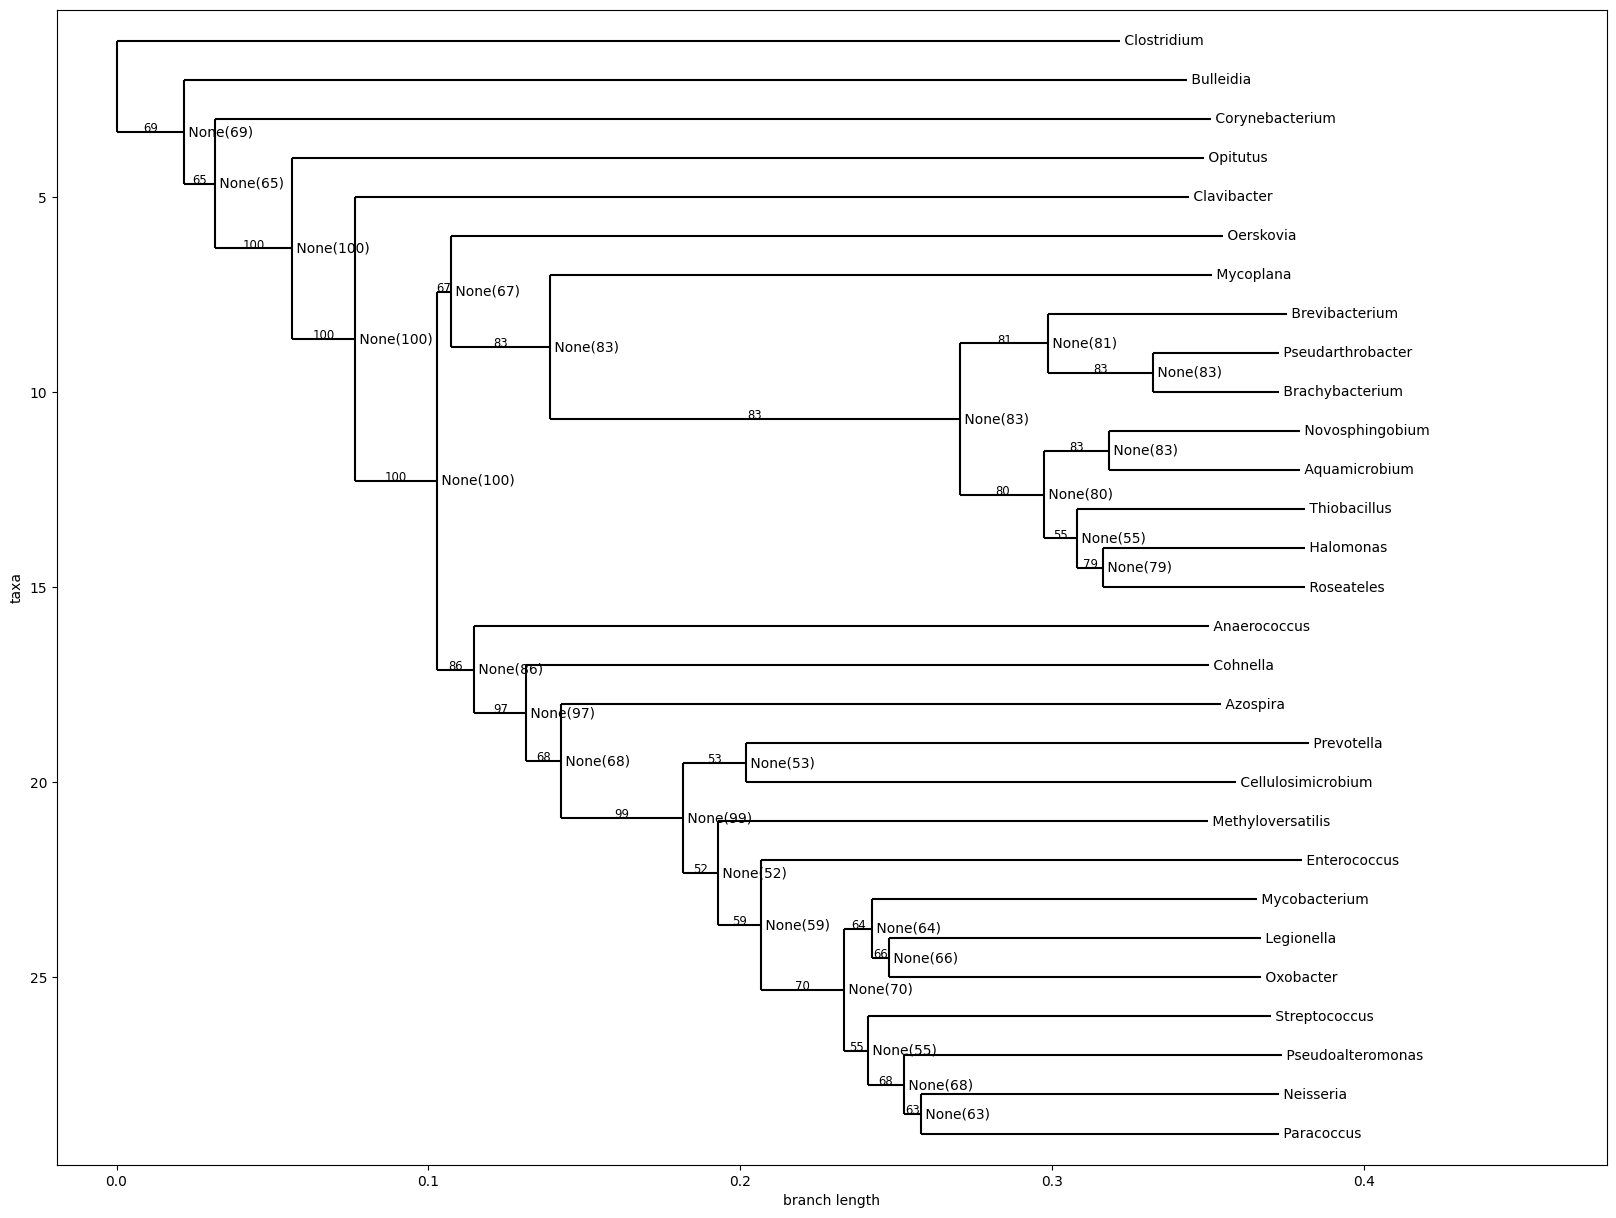

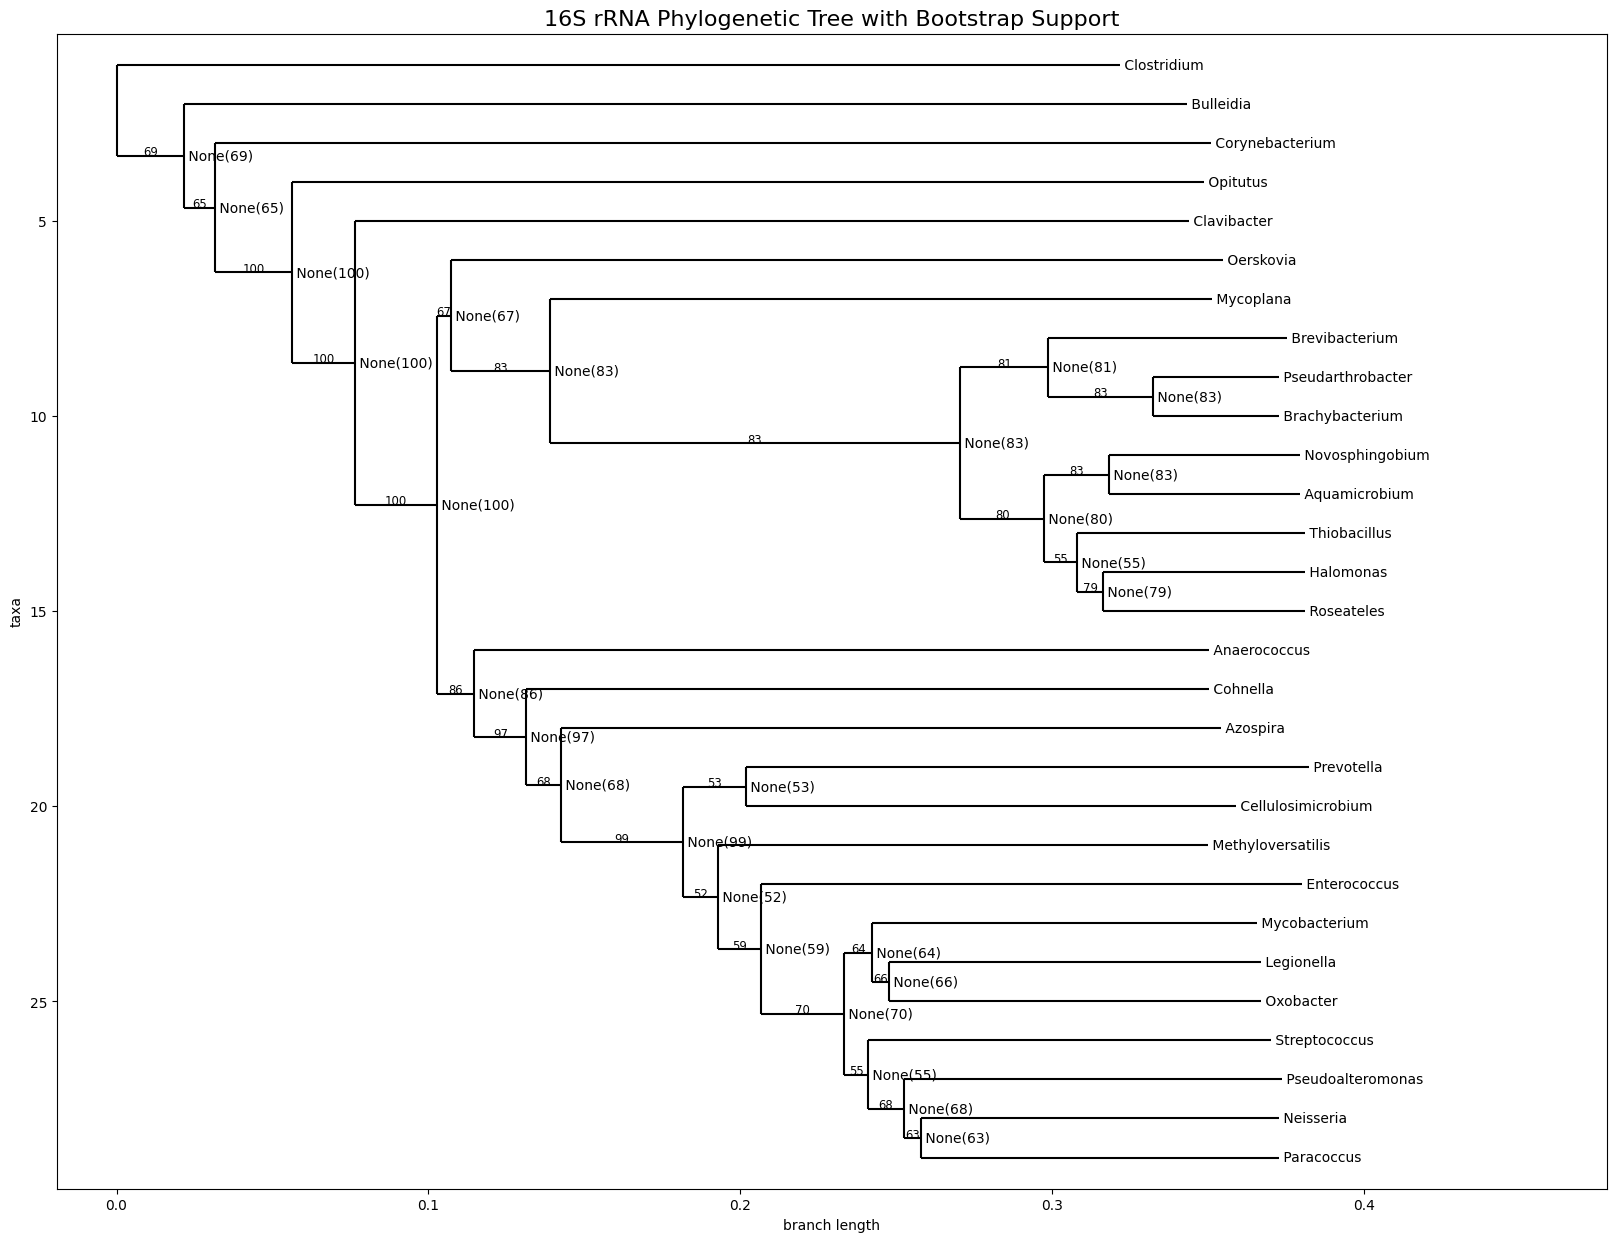

In [122]:
def plot_tree_with_annotations(consensus_tree, ax):
        
    # Draw tree with bootstrap values
    Phylo.draw(consensus_tree, 
               axes = ax, 
               show_confidence=True,
               label_func=lambda x: f"{x.name}" if x.confidence else x.name
    )

# Create the figure and axes outside the function
fig, ax = plt.subplots(figsize=(20, 15))

# Call the function, passing the external ax
plot_tree_with_annotations(consensus_tree, ax)

# Explicitly set the current axes to ensure the title is added to the correct subplot
plt.sca(ax)  # Set the current axes to `ax`
ax.set_title("16S rRNA Phylogenetic Tree with Bootstrap Support", fontsize=16)

# Display the plot
plt.show()

Note that there are two trees, that is because I didnt manage to put the title on the native Phylo tree and it was no possible to no draw the first one. The second one is more complete.

# 9. Interpretation of the Concensus Tree
High Confidence Clades: Several clades show very high bootstrap support (100%), particularly at deeper nodes in the tree. For example, the clade containing Clavibacter, Oerskovia and related genera has 100% support, indicating these groupings are highly reliable.
The relationship between Brevibacterium, Pseudarthrobacter and Brachybacterium is well-supported with bootstrap values of 81-83%.

Moderate Confidence Clades: Many clades show moderate support (60-80%). For example:
The clade containing Mycobacterium and Legionella (64-66% support). The grouping of Paracoccus and Neisseria (63-68% support). These moderate values suggest some uncertainty in these relationships, though they're still reasonably supported.

Taxonomic Implications: The tree shows clear separation between major bacterial groups. For example, Clostridium, Bulleidia, and Corynebacterium form an early-branching group.
Aquamicrobium and Novosphingobium cluster together (83% support), suggesting they share a more recent common ancestor.
The clustering of Methyloversatilis with Enterococcus and related genera suggests some interesting evolutionary relationships that might warrant further investigation.

Data Quality: The presence of many moderate to high bootstrap values (>60%) suggests generally good quality sequence data and alignment.
The tree shows a good mix of deep and shallow relationships, indicating the analysis captured both ancient and recent evolutionary events.
There are no extremely low bootstrap values (<50%), which supports the overall robustness of the analysis.

In [123]:
'''# Debugging
# check the function to generate replicates
for replicate in bootstrap_replicates:
    print(replicate)
# Store the concatenated replicates in the dictionary
bootstrap_replicates[0] = concatenated_replicates

# Print first bootstrap replicate to check
print('First bootstrap replicate:', bootstrap_replicates[0])
print("Number of sequences in alignment:", len(alignment))
print("IDs of sequences in alignment:", [record.id for record in alignment])

# # Tree basic info
for i, tree in enumerate(trees):
    print(f"Tree {i}: {tree}")
from Bio.Phylo.BaseTree import Tree
#Are the trees objects?
for i, tree in enumerate(trees):
    if not isinstance(tree, Tree):
        print(f"The element at index {i} is not a Tree object.")
        # Is the trees list empty?
if not trees:
    print("The list of trees is empty.")'''

'# Debugging\n# check the function to generate replicates\nfor replicate in bootstrap_replicates:\n    print(replicate)\n# Store the concatenated replicates in the dictionary\nbootstrap_replicates[0] = concatenated_replicates\n\n# Print first bootstrap replicate to check\nprint(\'First bootstrap replicate:\', bootstrap_replicates[0])\nprint("Number of sequences in alignment:", len(alignment))\nprint("IDs of sequences in alignment:", [record.id for record in alignment])\n\n# # Tree basic info\nfor i, tree in enumerate(trees):\n    print(f"Tree {i}: {tree}")\nfrom Bio.Phylo.BaseTree import Tree\n#Are the trees objects?\nfor i, tree in enumerate(trees):\n    if not isinstance(tree, Tree):\n        print(f"The element at index {i} is not a Tree object.")\n        # Is the trees list empty?\nif not trees:\n    print("The list of trees is empty.")'

# 10. Summarising the Results

In [124]:
def summarize_analysis(final_sequences, consensus_tree, output_dir):
    """Generate analysis summary"""
    summary = {
        'total_genera': len(final_sequences['Genus'].unique()),
        'sequences_retrieved': len(final_sequences),
        'avg_sequence_length': round(final_sequences['Sequence'].str.len().mean(), 4),
        'genera_list': ', '.join(final_sequences['Genus'].unique())
    }
    
    # Save summary
    with open(output_dir / 'analysis_summary.txt', 'w') as f:
        for key, value in summary.items():
            f.write(f"{key}: {value}\n")
            
    return summary

In [125]:
Summary = summarize_analysis(final_sequences, consensus_tree, base_dir)
Summary

{'total_genera': 29,
 'sequences_retrieved': 29,
 'avg_sequence_length': 1089.8276,
 'genera_list': 'Anaerococcus, Aquamicrobium, Azospira, Brachybacterium, Brevibacterium, Bulleidia, Cellulosimicrobium, Clavibacter, Clostridium, Cohnella, Corynebacterium, Enterococcus, Halomonas, Legionella, Methyloversatilis, Mycobacterium, Mycoplana, Neisseria, Novosphingobium, Oerskovia, Opitutus, Oxobacter, Paracoccus, Prevotella, Pseudarthrobacter, Pseudoalteromonas, Roseateles, Streptococcus, Thiobacillus'}

In [126]:
# Save the tree in Newick format
Phylo.write([consensus_tree], 'data_tree/consensus_tree.newick', 'newick')

1